In [1]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
import sys
sys.path.append("..")

import numpy as np
import harmonix
from harmonix.test_utils import get_ylm_FTs, v_scipy, v_mathematica
from harmonix.harmonix import Harmonix
from harmonix.utils import csphjy
from jax import config
import matplotlib.pyplot as plt
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Calculating the Fisher information of stellar interferometry

The statement of our transformation is:
$$\mathbf{V} = \mathrm{A} \mathbf{y}$$

where
$\mathrm{A}$ is $m\times n$, the design matrix \
$y \isin \mathbb{R}^n$, the spherical harmonic coefficient vector \
$V \isin \mathbb{C}^m$, the (observed) complex visibility vector

The Fisher information matrix for a linear regression $\mathbf{V} = A \mathbf{y}$ can be written:

$$\mathrm{FIM} = \mathrm{A}^\mathrm{H} \Sigma^{-1} \mathrm{A}$$

where $\Sigma$ is the data covariance matrix, which is $\mathbb{C}^{m \times m}$. Because we assume the data is IID, we should have:

$$\mathrm{FIM} = \frac{1}{\sigma^2} \mathrm{A}^\mathrm{H} \mathrm{A}$$

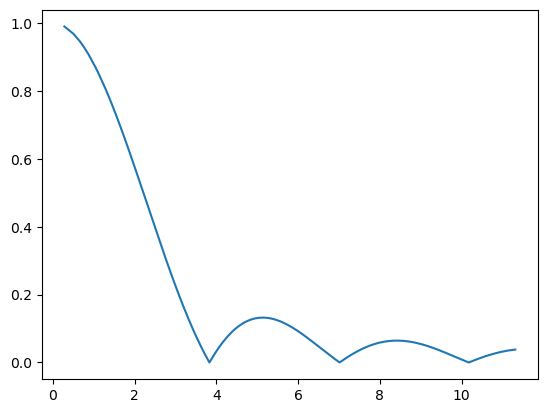

In [2]:
uu, vv = jnp.linspace(0.2,8,30),jnp.linspace(0.2,8,30)
u, v = jnp.meshgrid(uu, vv)
u = jnp.concatenate(u, axis=0)
v =  jnp.concatenate(v, axis=0)
inds = jnp.argsort(jnp.sqrt(u**2+v**2))
def ud(x):
    return 2*(jax.scipy.special.bessel_jn(x,v=1,n_iter=30)[1]/x)
    
plt.plot(jnp.sqrt(u[inds]**2+v[inds]**2), jnp.abs(ud(jnp.sqrt(u[inds]**2+v[inds]**2))))

In [3]:
ROTATIONAL_PHASES = 4
l_max = 8
UV_MAX = 8
def full_transform(y):
    uu, vv = jnp.linspace(0.1,UV_MAX,8),jnp.linspace(0.1,UV_MAX,8)
    u, v = jnp.meshgrid(uu, vv)
    u = jnp.concatenate(u, axis=0)
    v =  jnp.concatenate(v, axis=0)
    inds = jnp.argsort(jnp.sqrt(u**2+v**2))
    map = Harmonix(l_max, u[inds], v[inds])
    thetas = jnp.linspace(0,2*jnp.pi,ROTATIONAL_PHASES, endpoint=False)
    vis = vmap(map, in_axes=(None, None, 0, None))(jnp.pi/2,0.0,thetas,y)
    return jnp.concatenate(vis, axis=0)

lm_to_n = lambda l,m : l**2+l+m

def rearrange_m_inds(l_max):
    inds = []
    for m in range(-l_max,l_max+1):
        for l in range(abs(m), l_max+1):
            inds.append(lm_to_n(l,m))
    return jnp.array(inds)

nmax = lambda l_max: l_max**2 + 2 * l_max + 1

A = jax.jacfwd(full_transform)

In [4]:
y = np.zeros(nmax(l_max))
y[0] = 1.0
FIM = (1/(0.01**2))*jnp.conj(A(y)).T@A(y)
cov = jnp.linalg.inv(FIM)

The covariance matrix of the parameters should simply be 

$\mathrm{cov} = \mathrm{FIM}^{-1}$

In [5]:
jnp.linalg.matrix_rank(FIM)

Array(81, dtype=int64)

In [6]:
jnp.linalg.slogdet(cov)

(Array(1.+8.70113578e-25j, dtype=complex128),
 Array(-652.23119755, dtype=float64))

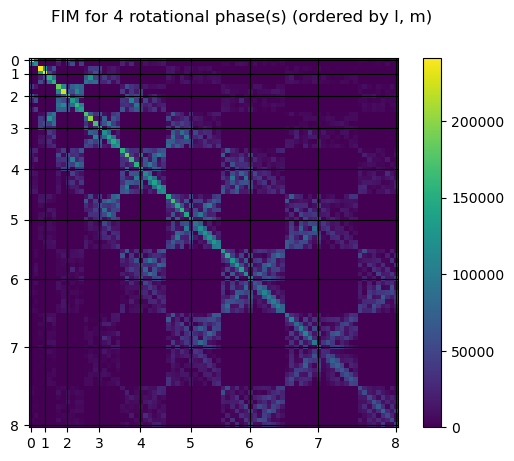

In [7]:
inds = rearrange_m_inds(l_max)
plt.imshow(jnp.abs(FIM)*jnp.sqrt(ROTATIONAL_PHASES))
tick_labels = jnp.arange(0,l_max+1)
tick_positions = [nmax(i)-1 for i in tick_labels]
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)
plt.grid(True,linestyle='-',color='black',alpha=1)
plt.suptitle(f"FIM for {ROTATIONAL_PHASES} rotational phase(s) (ordered by l, m)")
plt.colorbar()

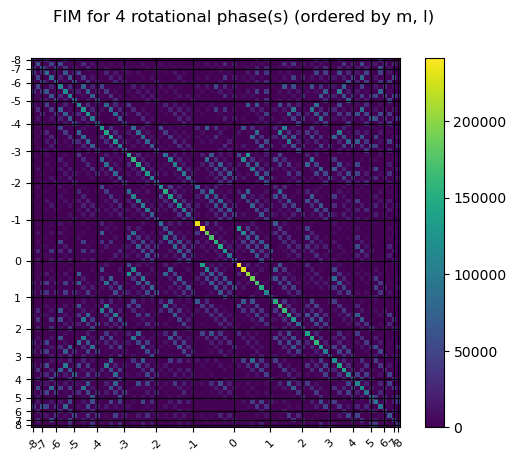

In [8]:
inds = rearrange_m_inds(l_max)
plt.imshow(jnp.abs(FIM)[inds][:, inds]*jnp.sqrt(ROTATIONAL_PHASES))
ind_counter = 0
tick_positions = []
for m in range(-l_max, l_max+1):
    ind_counter+=l_max+1-abs(m)
    tick_positions.append(ind_counter-1)
tick_labels = jnp.arange(-l_max,l_max+1)
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(rotation=45)
plt.grid(True,linestyle='-',color='black',alpha=1)
plt.suptitle(f"FIM for {ROTATIONAL_PHASES} rotational phase(s) (ordered by m, l)")
plt.colorbar()

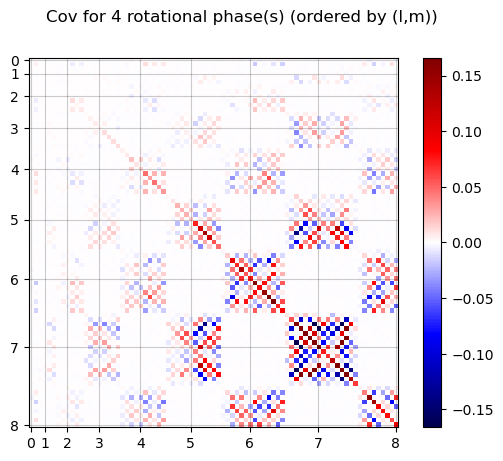

In [9]:
inds = rearrange_m_inds(l_max)
plt.imshow(jnp.real(cov)*jnp.sqrt(ROTATIONAL_PHASES), cmap='seismic', vmin=-jnp.max(jnp.real(cov)), vmax=jnp.max(jnp.real(cov)))
tick_labels = jnp.arange(0,l_max+1)
tick_positions = [nmax(i)-1 for i in tick_labels]
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)
plt.suptitle(f"Cov for {ROTATIONAL_PHASES} rotational phase(s) (ordered by (l,m))")
plt.grid(True,linestyle='-',color='black',alpha=0.2)
plt.colorbar()

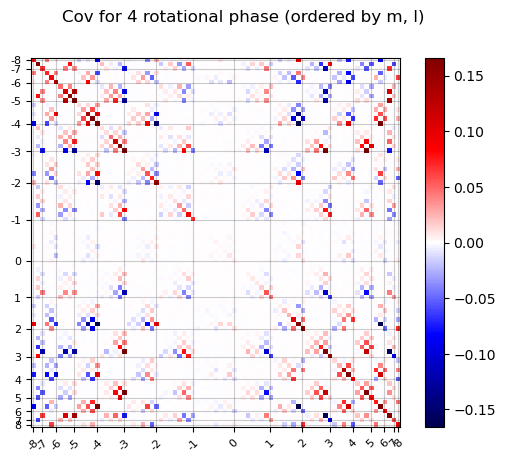

In [10]:
inds = rearrange_m_inds(l_max)
plt.imshow(jnp.real(cov)[inds][:, inds]*jnp.sqrt(ROTATIONAL_PHASES), cmap='seismic', vmin=-jnp.max(jnp.real(cov)), vmax=jnp.max(jnp.real(cov)))
ind_counter = 0
tick_positions = []
for m in range(-l_max, l_max+1):
    ind_counter+=l_max+1-abs(m)
    tick_positions.append(ind_counter-1)
    #plt.axhline(ind_counter-1)
    #plt.axvline(ind_counter-1)
tick_labels = jnp.arange(-l_max,l_max+1)
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(rotation=45)
plt.suptitle(f"Cov for {ROTATIONAL_PHASES} rotational phase (ordered by m, l)")
plt.grid(True,linestyle='-',color='black',alpha=0.2)
plt.colorbar()

In [11]:
from scipy.linalg import ishermitian, issymmetric
import numpy as np
ishermitian(np.array(FIM[inds][:, inds]), atol=1e-10)

True

In [12]:
issymmetric(np.array(FIM), atol=1e-8)

False

In [13]:
ishermitian(np.array(cov[inds][:, inds]), atol=1e-10)

True

In [14]:
issymmetric(np.array(cov), atol=1e-8)

False

(array([ 0,  2,  5,  9, 14, 20, 27, 35, 44, 52, 59, 65, 70, 74, 77, 79, 80]),
 [Text(0, 0, '-8'),
  Text(2, 0, '-7'),
  Text(5, 0, '-6'),
  Text(9, 0, '-5'),
  Text(14, 0, '-4'),
  Text(20, 0, '-3'),
  Text(27, 0, '-2'),
  Text(35, 0, '-1'),
  Text(44, 0, '0'),
  Text(52, 0, '1'),
  Text(59, 0, '2'),
  Text(65, 0, '3'),
  Text(70, 0, '4'),
  Text(74, 0, '5'),
  Text(77, 0, '6'),
  Text(79, 0, '7'),
  Text(80, 0, '8')])

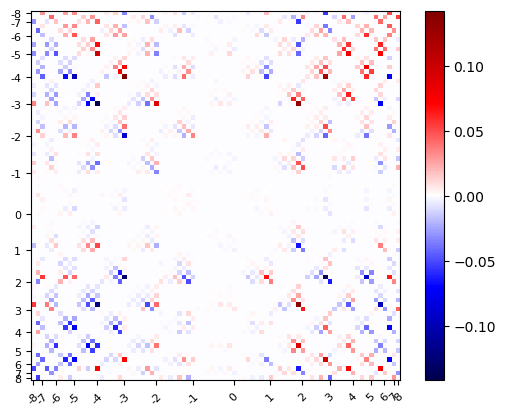

In [15]:
plt.imshow(jnp.imag(cov)[inds][:, inds],cmap='seismic')
plt.colorbar()
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(rotation=45)

In [16]:
jnp.allclose(jnp.abs(jnp.dot(FIM, cov))[inds][:, inds],jnp.eye(len(inds)), atol=1e-2)

Array(True, dtype=bool)